In [1]:
! pip install ucimlrepo

In [2]:
! pip install mlflow

In [3]:
! pip install "protobuf<6"

# Task 1: Data Acquisition & Exploratory Data Analysis (EDA)

Obtain the dataset (provide download script or instructions). Clean and preprocess the data (handle
missing values, encode features). Perform EDA with professional visualizations (histograms, correlation
heatmaps, class balance).


In [4]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

def download_data():
    print("Attempting to download Heart Disease dataset...")
    
    # Fetch dataset from UCI (ID 45 is the Heart Disease dataset)
    # This serves as the 'download script' required by the assignment
    try:
        heart_disease = fetch_ucirepo(id=45) 
        
        # Combine features (X) and target (y) into one DataFrame for EDA
        X = heart_disease.data.features
        y = heart_disease.data.targets
        
        # Create a full dataframe
        df = pd.concat([X, y], axis=1)
        
        # Save to CSV for reproducibility
        df.to_csv('heart_disease_raw.csv', index=False)
        print("Data downloaded and saved as 'heart_disease_raw.csv'")
        return df
    
    except Exception as e:
        print(f"Error downloading data: {e}")
        return None

# Execute download
df = download_data()

Attempting to download Heart Disease dataset...
Data downloaded and saved as 'heart_disease_raw.csv'


In [5]:
import numpy as np
import pandas as pd

def clean_and_preprocess(df):
    # 1. Handling Missing Values 
    # Check for nulls
    print("Missing values before cleaning:\n", df.isnull().sum())
    
    # Impute missing values
    df['ca'] = df['ca'].fillna(df['ca'].mode()[0])
    df['thal'] = df['thal'].fillna(df['thal'].mode()[0])
    
    # 2. Encoding Features 
    # The dataset has categorical variables like 'cp', 'restecg', 'slope', 'thal'
    # One-Hot Encoding is used for nominal variables and preserve ordinal ones if applicable - get_dummies
    
    # List of categorical columns to encode
    categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    
    # Create dummy variables (One-Hot Encoding)
    df_clean = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    
    # Ensure target column is properly named (UCI sometimes labels it 'num')
    # Map target: 0 = No Disease, 1-4 = Disease. Convert to Binary (0 vs 1)
    if 'num' in df_clean.columns:
        df_clean['target'] = df_clean['num'].apply(lambda x: 1 if x > 0 else 0)
        df_clean.drop(columns=['num'], inplace=True)
        
    print("Data cleaning and encoding complete.")
    return df_clean

# Apply cleaning
if df is not None:
    df_processed = clean_and_preprocess(df)
    df_processed.to_csv('heart_disease_cleaned.csv', index=False)

Missing values before cleaning:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64
Data cleaning and encoding complete.


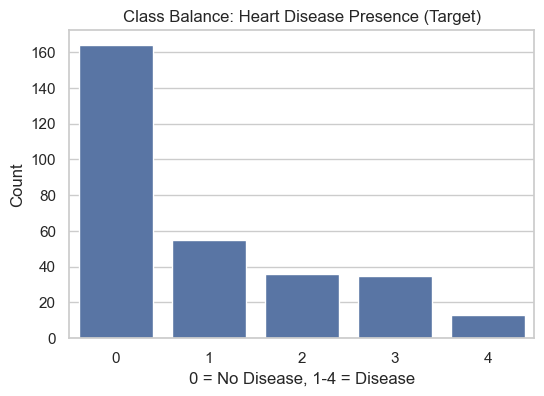

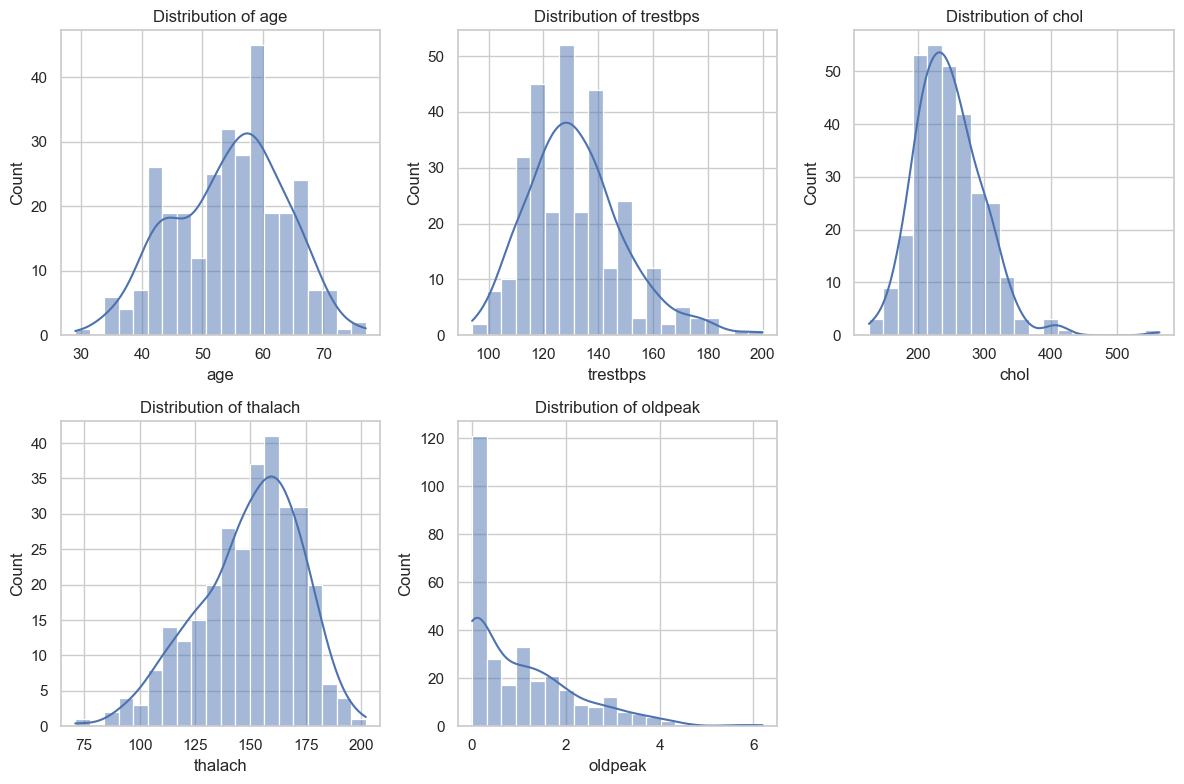

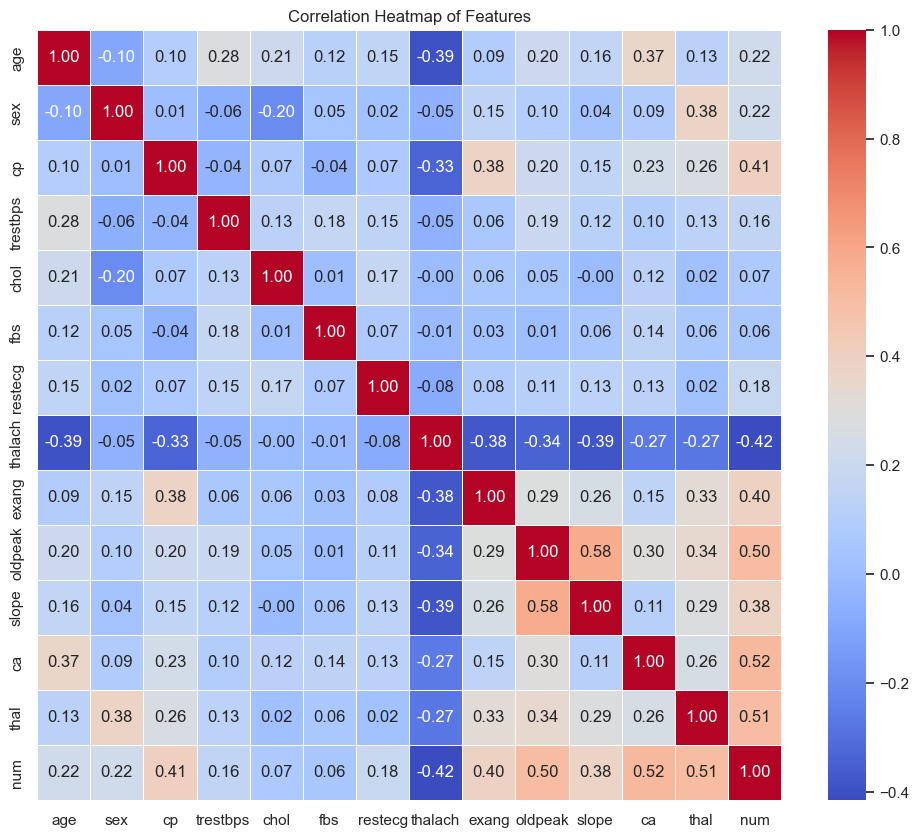

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def perform_eda(df):
    # Set visual style
    sns.set(style="whitegrid")

    # 1. Class Balance Visualization 
    plt.figure(figsize=(6, 4))
    sns.countplot(x='num', data=df) # Using original 'df' before encoding for clearer EDA
    plt.title('Class Balance: Heart Disease Presence (Target)')
    plt.xlabel('0 = No Disease, 1-4 = Disease')
    plt.ylabel('Count')
    plt.show()

    # 2. Histograms for Numerical Features 
    # Key numerical features: age, trestbps (blood pressure), chol, thalach (max heart rate), oldpeak
    num_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    
    plt.figure(figsize=(12, 8))
    for i, col in enumerate(num_features):
        plt.subplot(2, 3, i+1)
        sns.histplot(df[col], kde=True, bins=20)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

    # 3. Correlation Heatmap 
    plt.figure(figsize=(12, 10))
    # Select only numeric columns for correlation matrix
    numeric_df = df.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr()
    
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Heatmap of Features')
    plt.show()

# Run EDA on the original dataframe (easier to interpret before one-hot encoding)
if df is not None:
    perform_eda(df)

# Task 2: Feature Engineering & Model Development
Prepare the final ML features (scaling and encoding). Build and train at least two classification models (e.g.,
Logistic Regression and Random Forest). Document model selection and tuning process. Evaluate using
cross-validation and relevant metrics (accuracy, precision, recall, ROC-AUC).

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pickle

# Load the cleaned data from Task 1
df = pd.read_csv('heart_disease_cleaned.csv')

# Separate Features (X) and Target (y)
X = df.drop(columns=['target'])
y = df['target']

# Split into Train and Test sets (80% Train, 20% Test)
# Stratify ensures the class balance is preserved in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale Numerical Features
# It's best practice to fit the scaler ONLY on X_train to avoid data leakage
scaler = StandardScaler()

# Identify numerical columns
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for later use in reproducibility (Task 4)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Data split and scaled. Scaler saved as 'scaler.pkl'.")

Data split and scaled. Scaler saved as 'scaler.pkl'.


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# --- Model 1: Logistic Regression ---
# Tuning: 'C' (regularization strength) and 'solver'
lr_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

lr = LogisticRegression(max_iter=1000, random_state=42)
lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_train_scaled, y_train)

best_lr_model = lr_grid.best_estimator_
print(f"Best Logistic Regression Params: {lr_grid.best_params_}")


# --- Model 2: Random Forest ---
# Tuning: 'n_estimators' (trees), 'max_depth', and 'min_samples_split'
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)

best_rf_model = rf_grid.best_estimator_
print(f"Best Random Forest Params: {rf_grid.best_params_}")

Best Logistic Regression Params: {'C': 1, 'solver': 'liblinear'}
Best Random Forest Params: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}


--- Logistic Regression Performance ---
Accuracy: 0.8525
Precision: 0.8276
Recall: 0.8571
ROC-AUC: 0.9513

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.85      0.86        33
           1       0.83      0.86      0.84        28

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61

--- Random Forest Performance ---
Accuracy: 0.8852
Precision: 0.8387
Recall: 0.9286
ROC-AUC: 0.9416

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.85      0.89        33
           1       0.84      0.93      0.88        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



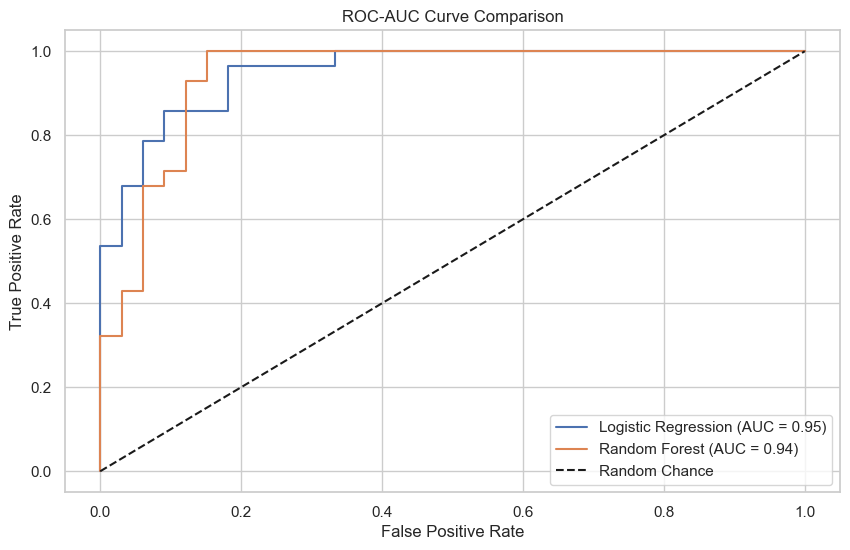

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, model_name):
    # Predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability for ROC-AUC
    
    # Calculate Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    print(f"--- {model_name} Performance ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"ROC-AUC: {auc:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    return y_prob, auc

# Evaluate both models
lr_prob, lr_auc = evaluate_model(best_lr_model, X_test_scaled, y_test, "Logistic Regression")
rf_prob, rf_auc = evaluate_model(best_rf_model, X_test_scaled, y_test, "Random Forest")

# --- Plot ROC Curve ---
plt.figure(figsize=(10, 6))

# Logistic Regression Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_prob)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_auc:.2f})')

# Random Forest Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve Comparison')
plt.legend()
plt.show()

# Task 3: Experiment Tracking
Integrate MLflow (or a similar tool) for experiment tracking. Log parameters, metrics, artifacts, and plots
for all runs.

In [10]:
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# --- 1. Setup MLflow ---
# This creates a folder named 'mlruns' in your current directory
mlflow.set_tracking_uri("file:./mlruns")
mlflow.set_experiment("Heart_Disease_Prediction")

def train_with_mlflow(model, model_name, X_train, y_train, X_test, y_test, params):
    """
    Trains a model and logs parameters, metrics, and artifacts to MLflow.
    """
    print(f"Starting run for: {model_name}...")
    
    # End any previous run that might have been left open
    if mlflow.active_run():
        mlflow.end_run()

    with mlflow.start_run(run_name=model_name):
        # A. Train
        model.fit(X_train, y_train)
        
        # B. Predict
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # C. Calculate Metrics
        metrics = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_prob)
        }
        
        # D. Log to MLflow
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)
        mlflow.sklearn.log_model(model, "model")  # Saves the model file
        
        # E. Log Artifacts (Confusion Matrix Plot)
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name} Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        
        # Save plot locally first, then log it
        plot_filename = "confusion_matrix.png"
        plt.savefig(plot_filename)
        plt.close() # Close to prevent display in notebook
        mlflow.log_artifact(plot_filename)
        
        # F. Log Scaler (if it exists from Task 2)
        if os.path.exists("scaler.pkl"):
            mlflow.log_artifact("scaler.pkl")
            
        print(f"Logged {model_name} successfully. Accuracy: {metrics['accuracy']:.4f}")

# --- 3. Execute Experiments ---
# We use the models and data prepared in Task 2

# Run Logistic Regression
lr_params = best_lr_model.get_params()
train_with_mlflow(best_lr_model, "Logistic_Regression", X_train_scaled, y_train, X_test_scaled, y_test, lr_params)

# Run Random Forest
rf_params = best_rf_model.get_params()
train_with_mlflow(best_rf_model, "Random_Forest", X_train_scaled, y_train, X_test_scaled, y_test, rf_params)

/opt/anaconda3/lib/python3.12/site-packages/pydantic/_internal/_fields.py:161: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
2026/01/06 17:01:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Starting run for: Logistic_Regression...
Logged Logistic_Regression successfully. Accuracy: 0.8525
Starting run for: Random_Forest...


2026/01/06 17:01:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Logged Random_Forest successfully. Accuracy: 0.8852


In [11]:
import os
import mlflow

# 1. Print the current tracking URI (where the code saved the data)
print(f"Current Tracking URI: {mlflow.get_tracking_uri()}")

# 2. If it's a local file path (usually starts with 'file:'), let's get the absolute path
current_dir = os.getcwd()
mlruns_path = os.path.join(current_dir, "mlruns")

print(f"\n--- COPY THIS PATH BELOW ---")
print(f"{mlruns_path}")
print("----------------------------")

Current Tracking URI: file:./mlruns

--- COPY THIS PATH BELOW ---
/Users/aalekhmacbook/Documents/BITS Pilani WILP/MLOPs/mlruns
----------------------------


In [12]:
import subprocess
import time

# 1. Kill old processes
try:
    subprocess.run(["pkill", "-f", "mlflow"])
except:
    pass

# 2. PASTE THE PATH from Step 1 into the variable below
# Example: absolute_path = "/Users/yourname/Documents/Project/mlruns"
absolute_path = "/Users/aalekhmacbook/Documents/BITS Pilani WILP/mlops_assignment/mlruns" 

# If you didn't paste it, we try to guess it automatically:
if absolute_path == "/Users/aalekhmacbook/Documents/BITS Pilani WILP/mlops_assignment/mlruns":
    import os
    absolute_path = os.path.join(os.getcwd(), "mlruns")

print(f"Launching MLflow reading from: {absolute_path}")

# 3. Start Server pointing to the specific backend store
# We use 'file://' prefix which is required
cmd = f'mlflow ui --backend-store-uri "file://{mlruns_path}" --port 5000'

process = subprocess.Popen(cmd, shell=True)

# 4. Wait a moment
time.sleep(4)
print("Dashboard is live at: http://127.0.0.1:5000")

Launching MLflow reading from: /Users/aalekhmacbook/Documents/BITS Pilani WILP/MLOPs/mlruns


/opt/anaconda3/lib/python3.12/site-packages/pydantic/_internal/_fields.py:161: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


Registry store URI not provided. Using backend store URI.


/opt/anaconda3/lib/python3.12/site-packages/mlflow/server/handlers.py:295: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, artifact_uri)
/opt/anaconda3/lib/python3.12/site-packages/mlflow/server/handlers.py:324: FutureWarning: The filesystem model registry backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import

Dashboard is live at: http://127.0.0.1:5000
INFO:     127.0.0.1:56960 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:56960 - "GET /static-files/manifest.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:56961 - "GET /static-files/static/js/main.3d3698b5.js HTTP/1.1" 200 OK
INFO:     127.0.0.1:56962 - "GET /static-files/static/css/main.280d6c90.css HTTP/1.1" 200 OK
INFO:     127.0.0.1:56964 - "GET / HTTP/1.1" 304 Not Modified
INFO:     127.0.0.1:56964 - "GET /ajax-api/2.0/mlflow/experiments/search?max_results=5&order_by=last_update_time+DESC HTTP/1.1" 200 OK


/opt/anaconda3/lib/python3.12/site-packages/mlflow/server/handlers.py:295: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, artifact_uri)


INFO:     127.0.0.1:56964 - "POST /graphql HTTP/1.1" 200 OK
INFO:     127.0.0.1:56964 - "GET /ajax-api/2.0/mlflow/traces?experiment_ids=793080823762442134&order_by=timestamp_ms%20DESC&max_results=1&filter= HTTP/1.1" 200 OK
INFO:     127.0.0.1:56967 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK
INFO:     127.0.0.1:56967 - "POST /ajax-api/2.0/mlflow/experiments/search-datasets HTTP/1.1" 200 OK
INFO:     127.0.0.1:56967 - "GET /ajax-api/2.0/mlflow/gateway-proxy?gateway_path=api%2F2.0%2Fendpoints%2F HTTP/1.1" 200 OK
INFO:     127.0.0.1:56964 - "POST /ajax-api/2.0/mlflow/logged-models/search HTTP/1.1" 200 OK
INFO:     127.0.0.1:56964 - "GET /ajax-api/2.0/mlflow/gateway-proxy?gateway_path=api%2F2.0%2Fendpoints%2F HTTP/1.1" 200 OK
INFO:     127.0.0.1:56967 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK


/opt/anaconda3/lib/python3.12/site-packages/mlflow/server/handlers.py:295: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, artifact_uri)


INFO:     127.0.0.1:56968 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK
INFO:     127.0.0.1:56977 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK
INFO:     127.0.0.1:56976 - "GET /ajax-api/2.0/mlflow/traces?experiment_ids=793080823762442134&order_by=timestamp_ms%20DESC&max_results=1&filter= HTTP/1.1" 200 OK


/opt/anaconda3/lib/python3.12/site-packages/mlflow/server/handlers.py:295: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, artifact_uri)


INFO:     127.0.0.1:56981 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK
INFO:     127.0.0.1:56987 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK
INFO:     127.0.0.1:56987 - "GET /ajax-api/2.0/mlflow/traces?experiment_ids=793080823762442134&order_by=timestamp_ms%20DESC&max_results=1&filter= HTTP/1.1" 200 OK
INFO:     127.0.0.1:56989 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK
INFO:     127.0.0.1:56992 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK
INFO:     127.0.0.1:57000 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK
INFO:     127.0.0.1:57015 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK
INFO:     127.0.0.1:57018 - "GET /ajax-api/2.0/mlflow/traces?experiment_ids=793080823762442134&order_by=timestamp_ms%20DESC&max_results=1&filter= HTTP/1.1" 200 OK
INFO:     127.0.0.1:57019 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK
INFO:     127.0.0.1:57029 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK
IN

/opt/anaconda3/lib/python3.12/site-packages/mlflow/server/handlers.py:295: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, artifact_uri)


INFO:     127.0.0.1:57067 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK
INFO:     127.0.0.1:57069 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK
INFO:     127.0.0.1:57078 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK


# Task 4: Model Packaging and Reproducibility
Save the final model in a reusable format (e.g., MLflow, pickle, ONNX). Write a clean requirements.txt (or
Conda env file). Provide a preprocessing pipeline/transformers to ensure full reproducibility.

In [14]:
import joblib
from sklearn.pipeline import Pipeline

# 1. Create the Inference Pipeline
# We combine the scaler (from Task 2) and the best model (e.g., Random Forest)
# This ensures raw input data is automatically scaled before prediction
pipeline_final = Pipeline([
    ('scaler', scaler),           # The scaler fitted in Task 2
    ('model', best_rf_model)      # The best hyper-tuned model from Task 2
])

# 2. Save the Pipeline to a file
# 'joblib' is efficient for saving scikit-learn models
model_filename = 'heart_disease_pipeline.pkl'
joblib.dump(pipeline_final, model_filename)

print(f"Model pipeline saved as '{model_filename}'")

# 3. Verification (Optional)
# Try loading it back to make sure it works
loaded_model = joblib.load(model_filename)
print("Model loaded successfully. Ready for inference.")

Model pipeline saved as 'heart_disease_pipeline.pkl'
Model loaded successfully. Ready for inference.
INFO:     127.0.0.1:51836 - "GET /ajax-api/2.0/mlflow/experiments/search?max_results=5&order_by=last_update_time+DESC HTTP/1.1" 200 OK


# Task 5: CI/CD Pipeline & Automated Testing

Write unit tests for data processing and model code (Pytest or unit test). Create a GitHub Actions (or
Jenkins) pipeline That Includes Linting, unit testing, and model training steps. Artifacts/logging for each
workflow run.